In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import gym
import matplotlib.pyplot as plt

In [ ]:
env =gym.make('FrozenLake-v0')

In [ ]:
#환경에 따라 input 및 output 사이즈 맞춰주기!
input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

In [ ]:
def one_hot(x):
    return np.identity(16)[x:x+1]

In [ ]:
X = tf.placeholder(shape=[1,input_size],dtype=tf.float32) # input state
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01)) # 가중치
Qpred = tf.matmul(X,W)   # Q-prediction 이 계산됨

기본적으로 X는 1 X 16 행렬

W는 각 상하좌우의 Q밸류가 추가된 형태인 16 X 4 행렬이 된다.

In [ ]:
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)  # y레이블

loss = tf.reduce_sum(tf.square(Y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [ ]:
#하이퍼 파라미터
dis = .99
num_episode = 2000

In [ ]:
# 매 애피소드 step의 총 reward를 담을 리스트임
rList = []

## 학습 파트

In [ ]:
init = tf.global_variables_initializer()  # 텐서플로에서 변수 초기화할때 쓰는거라고 함
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episode):
        # 환경을 리셋시켜주고, 새 관측을 얻음
        s = env.reset()
        e = 1. / ((i / 50) + 10)
        rAll = 0
        done = False
        local_loss = []

        # Q-Network training
        while not done:
            #그리디 혹은 랜덤한 방식을 통해 학습
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # 새 state로 이동 + 환경으로 부터 reward를 받음
            s1, reward, done, _ = env.step(a)
            if done:
                #터미널 상태에 있을때
                Qs[0, a] = reward
            else:
                #터미널 상태에 있지 않다면?
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                #Q를 업데이트 해줌
                Qs[0, a] = reward + dis * np.max(Qs1)

            sess.run(train, feed_dict= {X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1
        rList.append(rAll)

성공 에피소드0.4425 %


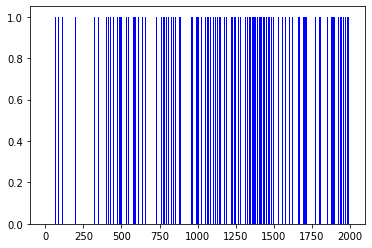

In [ ]:
print("성공 에피소드" + str(sum(rList)/num_episode) + " %")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

속도도 빠르지 않고 잘 수렴하지 않는 모습을 볼 수 있다

-> 미니배치 같은 것을 사용?
